In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorly as tl
from tensorly.decomposition import non_negative_parafac, non_negative_parafac_hals
from tlviz.factor_tools import factor_match_score
from itertools import combinations

## Load dataset

In [2]:
df_solar = pd.read_csv("data/solarPV.csv")
df_solar.shape

(333096, 180)

In [3]:
df_solar.head()

,Time,AL00,AT00,AT01,AT02,AT03,BA00,BE00,BE01,BE02,...,UA01,UA02,UK00,UK01,UK02,UK03,UK04,UK05,UKNI,XK00
0,01-Jan-1982 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01-Jan-1982 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01-Jan-1982 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01-Jan-1982 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01-Jan-1982 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# convert timestamp to DateTime format
df_solar['Time'] = pd.to_datetime(df_solar['Time'])
df_solar.head()

,Time,AL00,AT00,AT01,AT02,AT03,BA00,BE00,BE01,BE02,...,UA01,UA02,UK00,UK01,UK02,UK03,UK04,UK05,UKNI,XK00
0,1982-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1982-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1982-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1982-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1982-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# check for any missing records
full_range = pd.date_range(start=df_solar.Time.min(), end=df_solar.Time.max(), freq='H')
missing_dates = full_range.difference(df_solar.Time)
print("Missing Dates/Times:")
print(missing_dates)

Missing Dates/Times:
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


/var/folders/3q/00qtxbyd76b06zllb05rkbfr0000gn/T/ipykernel_65108/650944118.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df_solar.Time.min(), end=df_solar.Time.max(), freq='H')


In [6]:
# check for missing values
total_missing_values = df_solar.isnull().sum().sum()
print("Total missing values in data frame:", total_missing_values)

Total missing values in data frame: 0


## Extract relevant data and reformat

In [7]:
# choose most recent year, 2019
df_solar_2019 = df_solar[df_solar['Time'] >= pd.to_datetime('2019-01-01')]
df_solar_2019 = df_solar_2019.reset_index()
df_solar_2019 = df_solar_2019.drop(columns=['index'])
df_solar_2019

,Time,AL00,AT00,AT01,AT02,AT03,BA00,BE00,BE01,BE02,...,UA01,UA02,UK00,UK01,UK02,UK03,UK04,UK05,UKNI,XK00
0,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,2019-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,2019-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,2019-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# convert into numpy array
df_solar_hourly_np = df_solar_2019.drop(columns="Time")
hourly_solar_arr = df_solar_hourly_np.to_numpy()
hourly_solar_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
hourly_rows_per_slice = 24

# calculate the new shape
hourly_num_slices = hourly_solar_arr.shape[0] // hourly_rows_per_slice
hourly_num_columns = hourly_solar_arr.shape[1]

new_shape = (hourly_num_slices, hourly_rows_per_slice, hourly_num_columns)

# reshape the array: day x hour x place
hourly_solar_tensor = hourly_solar_arr.reshape(new_shape)

print("Original 2D array shape:", hourly_solar_arr.shape)
print("New 3D tensor shape:", hourly_solar_tensor.shape)

Original 2D array shape: (8760, 179)
New 3D tensor shape: (365, 24, 179)


In [10]:
print("Minimum value in dataset:", hourly_solar_tensor.min())
print("Maximum value in dataset:", hourly_solar_tensor.max())

Minimum value in dataset: 0.0
Maximum value in dataset: 0.89972276754818


## EDA

Number of zero entries: 806886
Number of nonzero entries: 761154


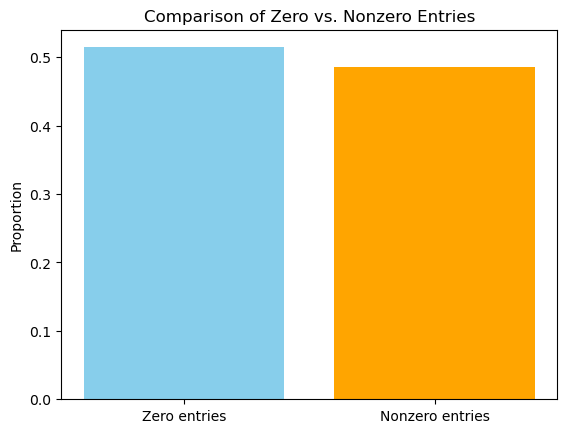

In [11]:
# check for the proportion of zero vs. nonzero entries
num_zeros = np.count_nonzero(hourly_solar_tensor == 0)
num_nonzeros = np.count_nonzero(hourly_solar_tensor)
total_entries = hourly_solar_tensor.shape[0]*hourly_solar_tensor.shape[1]*hourly_solar_tensor.shape[2]
print("Number of zero entries:", num_zeros)
print("Number of nonzero entries:", num_nonzeros)

# summarize in a bar plot
zero_labels = ['Zero entries', 'Nonzero entries']
zero_props = [num_zeros / total_entries, num_nonzeros / total_entries]

plt.bar(zero_labels, zero_props, color=['skyblue', 'orange'])
plt.ylabel('Proportion')
plt.title('Comparison of Zero vs. Nonzero Entries')

plt.show()

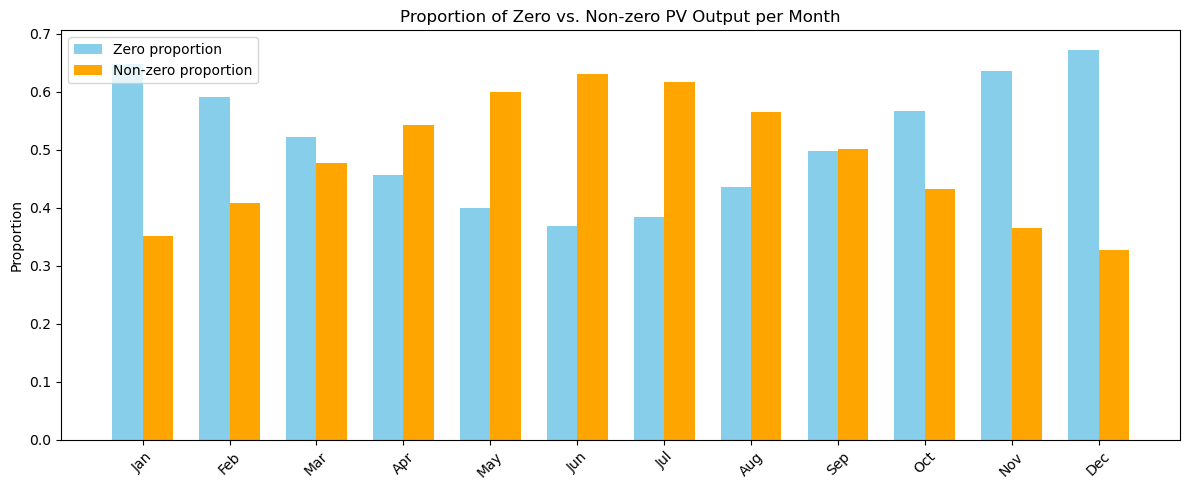

In [12]:
# number of days per month in a non-leap year
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# convert to start/end day indices
month_slices = []
start = 0
for d in days_in_month:
    month_slices.append(slice(start, start + d))
    start += d

zero_props = []
nonzero_props = []

# iterate through each month
for s in month_slices:
    block = hourly_solar_tensor[s, :, :]
    total = block.size
    zeros = np.sum(block == 0)
    nonzeros = total - zeros

    # count proportion of zeros vs. nonzeros per month
    zero_props.append(zeros / total)
    nonzero_props.append(nonzeros / total)

# make grouped bar plot
x = np.arange(len(month_names))
width = 0.35

plt.figure(figsize=(12, 5))

plt.bar(x - width/2, zero_props, width, label="Zero proportion", color="skyblue")
plt.bar(x + width/2, nonzero_props, width, label="Non-zero proportion", color="orange")

plt.xticks(x, month_names, rotation=45)
plt.ylabel("Proportion")
plt.title("Proportion of Zero vs. Non-zero PV Output per Month")
plt.legend()
plt.tight_layout()
plt.show()

## Compare decomposition algorithms

In [13]:
def compare_algos(tensor):
    ranks_to_test = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
    errors_mu = []
    errors_hals = []
    
    for rank in ranks_to_test:
        cp_nn_mu = non_negative_parafac(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0
        )

        cp_nn_hals = non_negative_parafac_hals(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0
        )
        
        # reconstruct the tensor
        X_hat_mu = tl.cp_to_tensor(cp_nn_mu)
        X_hat_hals = tl.cp_to_tensor(cp_nn_hals)
        
        # compute relative error
        error_mu = tl.norm(tensor - X_hat_mu) / tl.norm(tensor)
        errors_mu.append(error_mu)
        error_hals = tl.norm(tensor - X_hat_hals) / tl.norm(tensor)
        errors_hals.append(error_hals)
    
    # plot reconstruction error vs rank
    plt.figure(figsize=(5, 5))
    plt.plot(ranks_to_test, errors_mu, marker='o', label="MU")
    plt.plot(ranks_to_test, errors_hals, marker='o', label="HALS")
    plt.title("Reconstruction Error vs. CP Rank")
    plt.xlabel("Rank")
    plt.ylabel("Relative Reconstruction Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

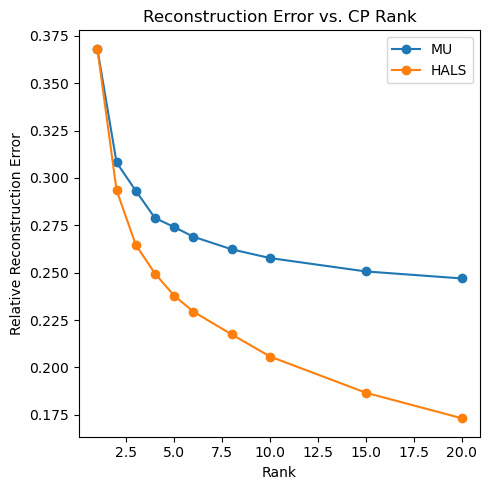

In [14]:
compare_algos(hourly_solar_tensor)

## Make rank selection

In [15]:
def compare_hals(tensor):
    ranks_to_test = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
    errors_hals = []
    
    for rank in ranks_to_test:
        cp_nn_hals = non_negative_parafac_hals(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0
        )
        
        # reconstruct the tensor
        X_hat_hals = tl.cp_to_tensor(cp_nn_hals)
        
        # compute relative error
        error_hals = tl.norm(tensor - X_hat_hals) / tl.norm(tensor)
        errors_hals.append(error_hals)
    
    # plot reconstruction error vs rank
    plt.figure(figsize=(5, 5))
    plt.plot(ranks_to_test, errors_hals, marker='o')
    plt.title("Reconstruction Error vs. CP Rank for HALS")
    plt.xlabel("Rank")
    plt.ylabel("Relative Reconstruction Error")
    plt.tight_layout()
    plt.show()

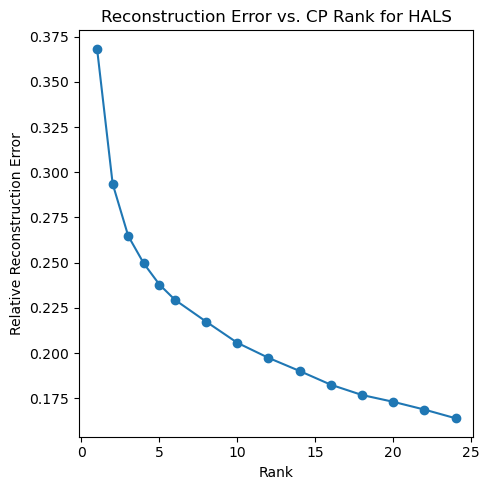

In [16]:
compare_hals(hourly_solar_tensor)

## Run for multiple initializations

In [17]:
def run_multiple_initializations(tensor, rank, n_init=5, max_iter=30):
    decomps = []
    # iterate through multiple random iterations
    for seed in range(n_init):
        rng = np.random.default_rng(seed)

        # perform non-negative decomp via HALS
        cp = non_negative_parafac_hals(
            tensor, 
            rank=rank,
            n_iter_max=max_iter,
            init='random',
            random_state=seed,
            normalize_factors=True
        )
        decomps.append((cp.weights, cp.factors))
    return decomps

def compute_stability(decomps):
    n = len(decomps)
    scores = np.zeros((n, n))

    # for each unique pair of decompositions, find their factor match score
    for i in range(n):
        for j in range(i+1, n):
            score = factor_match_score(decomps[i], decomps[j])
            scores[i, j] = score
            scores[j, i] = score
    
    # upper-triangle values, excluding diagonal
    upper_vals = scores[np.triu_indices(n, k=1)]
    return np.mean(upper_vals), np.std(upper_vals), scores

In [18]:
ranks = range(1, 20)
n_init = 5

results = {}
continue_rank_search = True

for r in ranks:
    print("\n--- Rank "+str(r)+" ---")
    decomps = run_multiple_initializations(hourly_solar_tensor, rank=r, n_init=n_init)

    # check for rank too high (i.e. one weight is zero, means rank is too high)
    for i in range(len(decomps)):
        if sum(decomps[i][0] == 0) >= 1:
            print("At least one factor weight is 0 for rank-"+str(r)+" decomposition.")
            continue_rank_search = False
            break

    if not continue_rank_search:
        break
    
    mean_fms, std_fms, matrix = compute_stability(decomps)
    
    print(f"Mean factor match score: {mean_fms:.4f}")
    print(f"Std factor match score:  {std_fms:.4f}")
    
    results[r] = {
        'mean_fms': mean_fms,
        'std_fms': std_fms,
        'matrix': matrix
    }


--- Rank 1 ---
Mean factor match score: 1.0000
Std factor match score:  0.0000

--- Rank 2 ---
Mean factor match score: 0.9985
Std factor match score:  0.0012

--- Rank 3 ---
Mean factor match score: 0.8931
Std factor match score:  0.1141

--- Rank 4 ---
Mean factor match score: 0.7071
Std factor match score:  0.1088

--- Rank 5 ---
At least one factor weight is 0 for rank-5 decomposition.


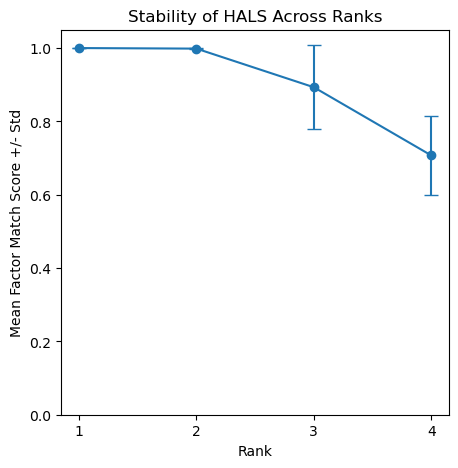

In [19]:
# extract ranks, mean FMS, and std FMS from the results dictionary
ranks = sorted(results.keys())
mean_fms = [results[r]['mean_fms'] for r in ranks]
std_fms = [results[r]['std_fms'] for r in ranks]

# create the plot
plt.figure(figsize=(5, 5))
plt.errorbar(ranks, mean_fms, yerr=std_fms, fmt='-o', capsize=5, markersize=6)
plt.xlabel("Rank")
plt.ylabel("Mean Factor Match Score +/- Std")
plt.title("Stability of HALS Across Ranks")
plt.xticks(ranks)
plt.ylim(0, 1.05)  # factor match score between 0 and 1
plt.show()

## Perform decomposition

In [20]:
def compute_and_plot_factors(tensor, rank, algo):
    # perform Non-Negative PARAFAC decomposition
    # for MU
    if algo == "MU":
        hourly_cp_nn = non_negative_parafac(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0,
            normalize_factors=True
        )
    # for HALS
    elif algo == "HALS":
        hourly_cp_nn = non_negative_parafac_hals(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0,
            normalize_factors=True
        )
    # for general CP
    elif algo == "PARAFAC":
        hourly_cp_nn = parafac(
            tensor,
            rank=rank,
            init='svd',
            n_iter_max=30,
            tol=1e-6,
            verbose=0
        )
    else:
        print("Choose either MU, HALS, or PARAFAC as algorithm.")
        return
    
    # store weights and factors
    weights = hourly_cp_nn.weights
    factors = hourly_cp_nn.factors
    
    # extract each factor
    hourly_A = factors[0]   # days
    hourly_B = factors[1]   # hours
    hourly_C = factors[2]   # locations

    fig, axes = plt.subplots(rank, 3, figsize=(10, 3*rank))

    days = np.arange(hourly_A.shape[0])
    hours = np.arange(hourly_B.shape[0])
    regions = np.arange(hourly_C.shape[0])
    
    for r in range(rank):
    
        # day factor
        ax = axes[r, 0]
        ax.plot(days, hourly_A[:, r], lw=2)
        ax.set_title(f"Component {r+1}: Daily Factor")
        ax.set_xlabel("Day of Year")
        ax.set_ylabel("Value")
        ax.grid(True)
    
        # hourly factor
        ax = axes[r, 1]
        ax.plot(hours, hourly_B[:, r], lw=2, color='orange')
        ax.set_title(f"Component {r+1}: Hourly Factor")
        ax.set_xlabel("Hour of Day")
        ax.grid(True)
    
        # location factor
        ax = axes[r, 2]
        # reshape to 2D array
        heatmap_data = hourly_C[:, r].reshape(1, -1)
        im = ax.imshow(heatmap_data, aspect='auto', cmap='viridis')
        ax.set_title(f"Component {r+1}: Location Factor")
        ax.set_xlabel("Region Index")
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

    # plot component weights
    plt.figure(figsize=(4, 4))
    plt.bar(range(1, rank+1), weights, color='purple')
    plt.xticks(range(1, rank+1))
    plt.xlabel("Component")
    plt.ylabel("Weight")
    plt.title("CP Decomposition Component Weights")
    plt.show()

    return weights, factors

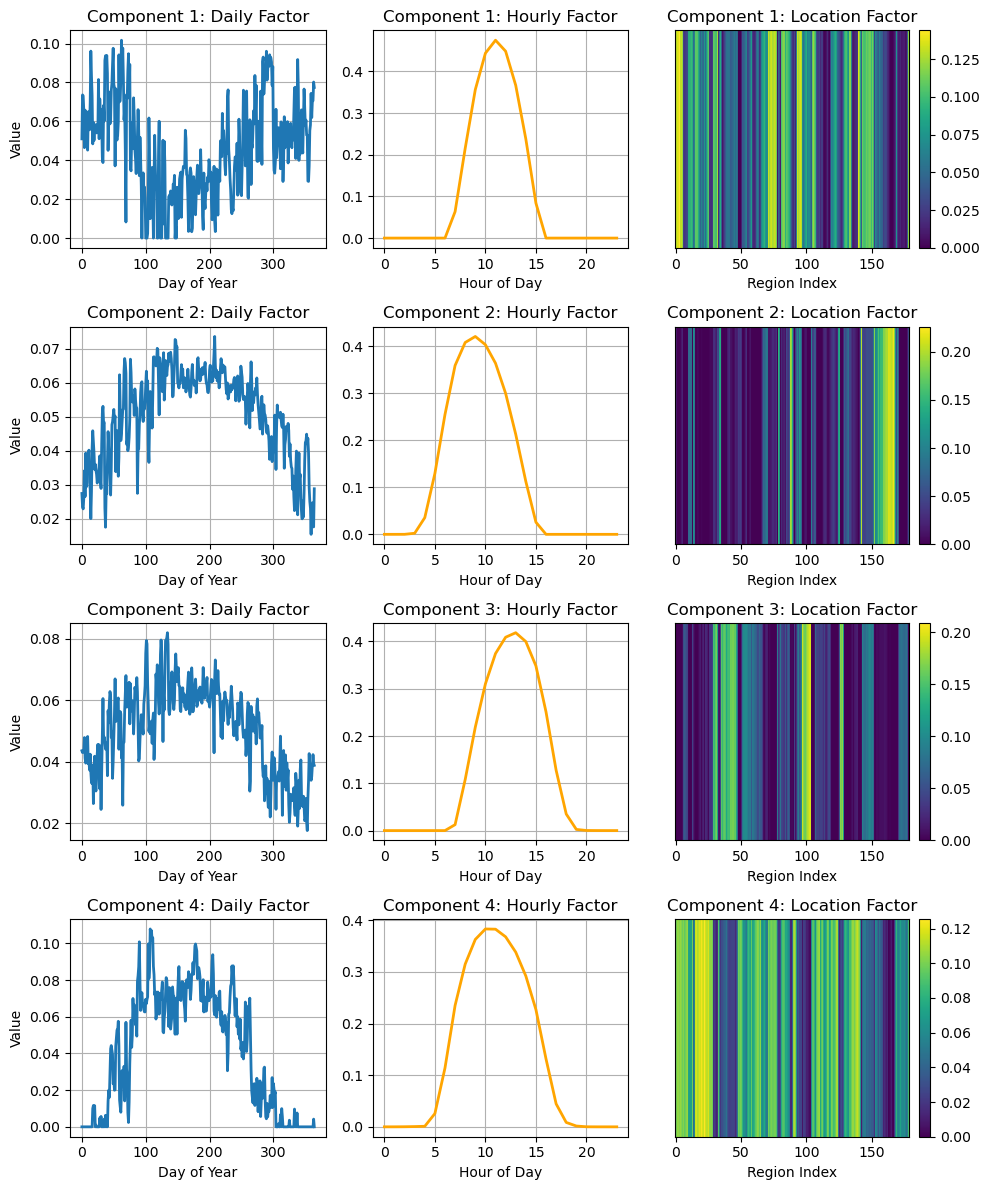

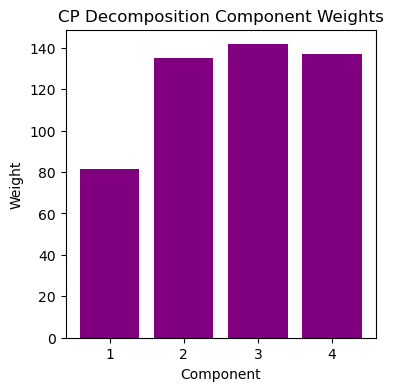

In [21]:
weights, factors = compute_and_plot_factors(hourly_solar_tensor, 4, "HALS")

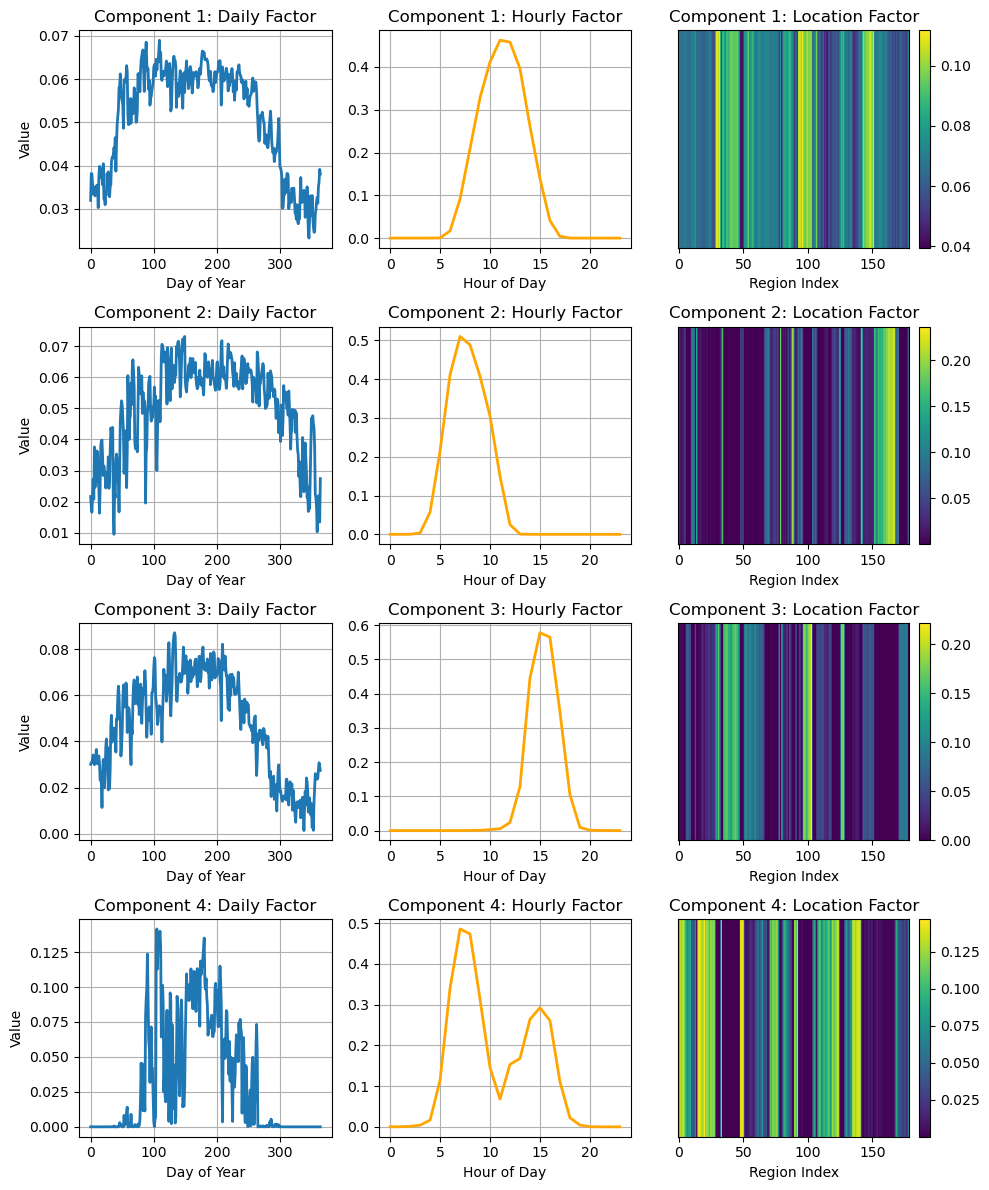

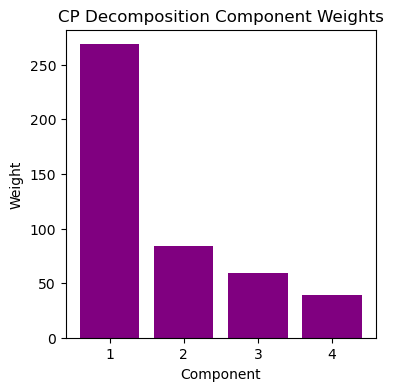

In [22]:
mu_weights, mu_factors = compute_and_plot_factors(hourly_solar_tensor, 4, "MU")

## Verify identifiability

In [23]:
# find the kruskal rank of a given matrix
def kruskal_rank(matrix):
    n_cols = matrix.shape[1]
    # check subsets of columns of size k from largest to smallest
    for k in range(n_cols, 0, -1):
        all_independent = True
        for cols in combinations(range(n_cols), k):
            submatrix = matrix[:, cols]
            # check if dependent columns
            if np.linalg.matrix_rank(submatrix) < k:
                all_independent = False
                break
        if all_independent:
            return k
    return 0

A = factors[0]
B = factors[1]
C = factors[2]

kruskal_A = kruskal_rank(A)
kruskal_B = kruskal_rank(B)
kruskal_C = kruskal_rank(C)

print("Kruskal ranks:")
print("A:", kruskal_A)
print("B:", kruskal_B)
print("C:", kruskal_C)

Kruskal ranks:
A: 4
B: 4
C: 4
